# Main process to remove Forgeound Point Source.

In this nothbook, we remove the foreground point source and fill in its place with the background value estimated by Source Extractor. Since Source Extractor can only be applied to 2D-images, it involves seperating the datacube for each channel and then combining it again.

# Contents

1. Primary beam Correction.
2. Crop the required area for the Datacube.
3. Create Source Extractor configuration file and parameter file
4. Run Source Extractor for each channel.
5. Creation of datacube consisting only of detected sources.
6. Subtract the detected source from the original datacube.

In [96]:
import numpy as np
from astropy.io import fits
import os
import matplotlib.pyplot as plt
from astropy.io.fits import getheader
from astropy.io.fits import getdata

In [97]:
#================= Define the path to the package
dir_path = '/path/to/package/KORSDC_FGremove/'
#==================================================

In [ ]:
import sys
sys.path.append(dir_path+"tools")
from tools import RA_DEC_fq 

In [98]:
input_file_path = dir_path+'input/'
output_file_path = dir_path+'output/'

#### A function that cuts a data cube to the desired size.

In [99]:
def crop_datacube(datacube, xsize, ysize, output_file_path):
    data = datacube.data
    header = datacube.header
    refx = int(header['CRPIX1'])
    refy = int(header['CRPIX2'])
    cropped_data = data[:, refy-int(ysize/2):refy+int(ysize/2), refx-int(xsize/2):refx+int(xsize/2)]
    header['CRPIX1'] = int(xsize/2)
    header['CRPIX2'] = int(ysize/2)
    os.chdir(output_file_path)
    fits.writeto('ZW3.msw_image_pbcor_%s_%scrop.fits' %(xsize, ysize), np.array(cropped_data, dtype='float32'), header, overwrite=True)
    
    plt.figure(figsize=(4,2), dpi=300)
    plt.subplots_adjust(hspace=10)
    plt.subplot(1,2,1)
    plt.imshow(data[500])
    plt.title('Original cube Frequency : 156.00 MHz', fontsize=5)
    plt.xticks(fontsize=5)
    plt.yticks(fontsize=5)
    
    plt.subplot(1,2,2)
    plt.imshow(cropped_data[500])
    plt.title('Cropped cube Frequency : 156.00 MHz', fontsize=5)
    plt.xticks(fontsize=5)
    plt.yticks(fontsize=5)
    
    return print ('The datacube was cropped to size %sx%s.' %(xsize, ysize))

#### Primary Beam Correction

In [100]:
def beam_correction(xsize, ysize):

    # Read image input
    ########## 'ZW3.msw_image.fits' is too large to be shared here,
    ########## so please find the intput via the link and download to the 'input' directory
    # ref. https://drive.google.com/drive/folders/13hHi5KJlX2GUrSJxuhCEqsjo0s5UgCXp
    datafile = input_file_path+'ZW3.msw_image.fits'
    print("Reading... ", datafile)
    fx = fits.open(datafile)
    RA, DEC, fq = RA_DEC_fq(fx)

    # cut image input
    header = getheader(datafile, 0) 
    refx = int(header['CRPIX1'])
    refy = int(header['CRPIX2'])
    cropped_data = fx['PRIMARY'].data[:, refy-int(ysize/2):refy+int(ysize/2), refx-int(xsize/2):refx+int(xsize/2)]
    header['CRPIX1'] = int(xsize/2)
    header['CRPIX2'] = int(ysize/2)

    # Cut Beam into the same shape that the image has:
    beamfile=dir_path+'ancillary/station_beam.fits'
    print("Reading... ", beamfile)
    fx_beam = fits.open(beamfile)
    RA1, DEC1, fq1 = RA_DEC_fq(fx_beam)


    header_beam = getheader(beamfile, 0) 
    refx = int(header_beam['CRPIX1'])
    refy = int(header_beam['CRPIX2'])
    cropped_beam = fx_beam['PRIMARY'].data[:, refy-int(ysize/2):refy+int(ysize/2), refx-int(xsize/2):refx+int(xsize/2)]


    Tx = cropped_data/cropped_beam
    fits.writeto(input_file_path+'ZW3.msw_image_pbcor.fits', np.array(Tx, dtype='float32'), header, overwrite=True)

    return print ('Now, the image cube is primary beam corrected.')

#### A function that creates a configuration file and parameter file to run Source Extractor.

In [101]:
def make_param_file(parameter_set):
    fm = open('%s.params' %(cname), 'w')
    for i in range(len(parameter_set)):
        fm.write('%s\n' %(parameter_set[i]))
    fm.close()
    return print ('The configuration file and parameter setting file have been created')

#### A function that cuts the image for each channel from the datacube and then runs the Source Extractor.

In [102]:
def run_se(data, header, config_file, param_file):
    header['NAXIS'] == 2   
    os.system('mkdir catalogue')
    os.system('mkdir source_only_images')
    for i in range(len(data)):
        fits.writeto('tmp_%s.fits' %(i), data[i], header, overwrite=True)
        os.system('./sex tmp_%s.fits -c %s -CATALOG_NAME cat_%s.dat -PARAMETERS_NAME %s -FILTER %s \
                  -CLEAN %s -PHOT_APERTURES %s -BACK_SIZE %s -BACK_FILTERSIZE %s\
                  -BACKPHOTO_TYPE %s -CHECKIMAGE_TYPE %s -CHECKIMAGE_NAME obj_only_%s.fits' \
                  %(i, config_file, i, param_file, FILTER, CLEAN, PHOT_APERTURES, BACK_SIZE, BACK_FILTERSIZE, \
                    BACKPHOTO_TYPE, CHECKIMAGE_TYPE,i))
        os.system('rm -rf tmp*.fits')
        os.system('mv cat_*.dat catalogue')
        os.system('mv obj_only_*.fits source_only_images')
    return print ('Source Extractor was performed normally for all channels.')
    

#### A function that creates a datacube composed only of sources detected with the Source Extractor.

In [103]:
def make_obj_cube(crop_data):
    os.chdir(output_file_path + '/source_only_images')
    data = crop_data.data
    header = crop_data.header
    source_cube = np.zeros(data.shape[0]*data.shape[1]*data.shape[2]).\
        reshape(data.shape[0],data.shape[1],data.shape[2])
    for i in range(len(data)):
        f1 = fits.open('obj_only_%s.fits' %(i))
        source_cube[i] = np.array(f1[0].data, dtype='float32')
        #print ('obj_%s complete...' %(i))
    source_cube = np.array(source_cube, dtype='float32')
    fits.writeto('source_only_cube_BS%s_BF%s.fits' %(BACK_SIZE, BACK_FILTERSIZE), np.array(source_cube, dtype='float32'), header, overwrite=True)
    os.system('mv source_only_cube_BS%s_BF%s.fits ../' %(BACK_SIZE, BACK_FILTERSIZE))
    #os.system('rm -rf obj_*.fits')
    
    plt.figure(figsize=(5,5), dpi=300)
    plt.subplots_adjust(hspace=2)
    plt.subplot(1,2,1)
    plt.imshow(data[500])
    plt.title('source only cube Frequency : 156.00MHz', fontsize=5)
    plt.xticks(fontsize=5)
    plt.yticks(fontsize=5)
    
    plt.subplot(1,2,2)
    plt.imshow(data[800])
    plt.title('source only cube Frequency : 186.00MHz', fontsize=5)
    plt.xticks(fontsize=5)
    plt.yticks(fontsize=5)
    
    return print ('Source only cube was created normally.')

#### A function that subtracts detected sources from the original datacube.

In [104]:
def obj_sub_cube(original_cube, source_only_cube):
    os.chdir(output_file_path)
    new_cube = original_cube.data - source_only_cube.data
    fits.writeto('source_sub_cube_BS%s_BF%s.fits' %(BACK_SIZE, BACK_FILTERSIZE), np.array(new_cube, dtype='float32'), original_cube.header, overwrite=True)
    
    plt.figure(figsize=(5,5), dpi=300)
    plt.subplot(2,2,1)
    plt.imshow(original_cube.data[500])
    plt.title('original cube Frequency = 156.00MHz', fontsize=5)
    plt.xticks(fontsize=5)
    plt.yticks(fontsize=5)
    
    plt.subplot(2,2,2)
    plt.imshow(new_cube[500])
    plt.title('source subtracted cube Frequency = 156.00MHz', fontsize=5)
    plt.xticks(fontsize=5)
    plt.yticks(fontsize=5)
    
    plt.subplot(2,2,3)
    plt.imshow(original_cube.data[800])
    plt.title('original cube Frequency = 186.00MHz', fontsize=5)
    plt.xticks(fontsize=5)
    plt.yticks(fontsize=5)
    
    plt.subplot(2,2,4)
    plt.imshow(new_cube[800])
    plt.title('source subtracted cube Frequency = 186.00MHz', fontsize=5)
    plt.xticks(fontsize=5)
    plt.yticks(fontsize=5)
    
    return print ('Source subtracted cube was created normally.')

## 1. Primary Beam Correction.

In [105]:
xsize = 900
ysize = 900
beam_correction(xsize, ysize)

Reading...  /home/dhlee/SDC3/MainData/ZW3.msw_image.fits
RA range      : -4.55 to 4.55
DEC range     : -34.55 to -25.45
redshift range: 6.24 to 12.40
Reading...  /home/dhlee/SDC3/TestData/station_beam.fits
RA range      : -5.69 to 5.68
DEC range     : -35.68 to -24.31
redshift range: 6.24 to 12.40
Now, the image cube is primary beam corrected.


## 2. Crop the required area for the Datacube.

The datacube was cropped to size 900x900.


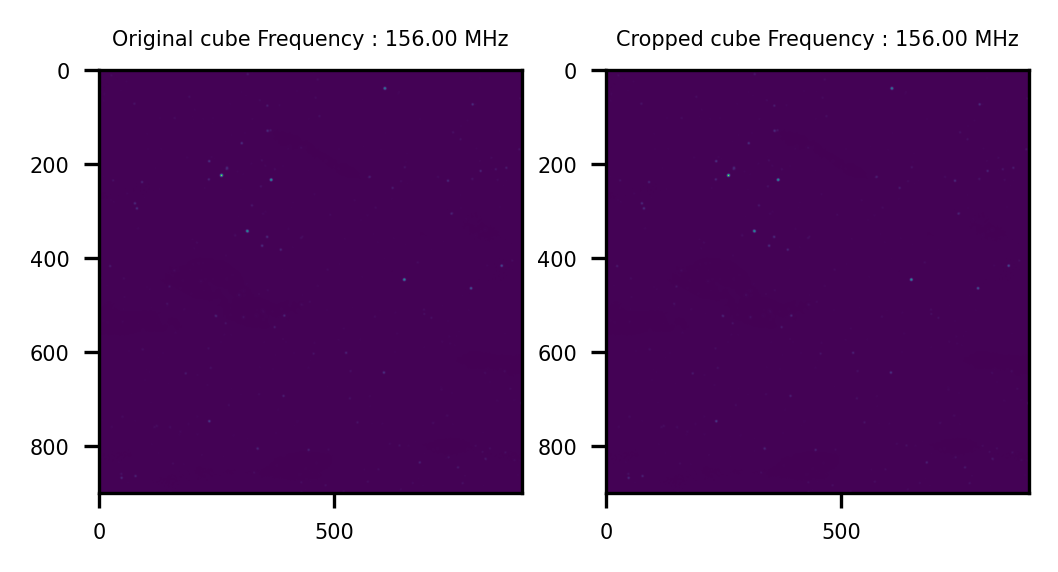

In [106]:
original_cube = fits.open(input_file_path + 'ZW3.msw_image_pbcor.fits')[0]

crop_datacube(original_cube, xsize, ysize, output_file_path)
crop_cube = fits.open(output_file_path + 'ZW3.msw_image_pbcor_%s_%scrop.fits' %(xsize, ysize))[0]

## 3. Create Source Extractor configuration file and parameter file

This is the parameter setting part of the Source Extractor required for background estimation.

In [107]:
os.chdir(output_file_path)

cname = 'default'       # Configuration and parameter file name
FILTER = 'N'
CLEAN = 'N'
PHOT_APERTURES = 20
BACK_SIZE = 20
BACK_FILTERSIZE = 1
BACKPHOTO_TYPE = 'LOCAL' #set GLOBAL or LOCAL
CHECKIMAGE_TYPE = 'OBJECTS'

os.system('./sex -d > %s.conf' %(cname))
param_set = ['NUMBER', 'MAG_APER', 'MAGERR_APER', 'X_IMAGE', 'Y_IMAGE', ]
config_file = '%s.conf' %(cname)
param_file = '%s.params' %(cname)
make_param_file(param_set)

The configuration file and parameter setting file have been created


./sex: error while loading shared libraries: libmkl_intel_lp64.so.1: cannot open shared object file: No such file or directory


## 4. Run Source Extractor for each channel.

In [ ]:
run_se(crop_cube.data, crop_cube.header, config_file, param_file)

## 5. Creation of datacube consisting only of detected sources.

Source only cube was created normally.


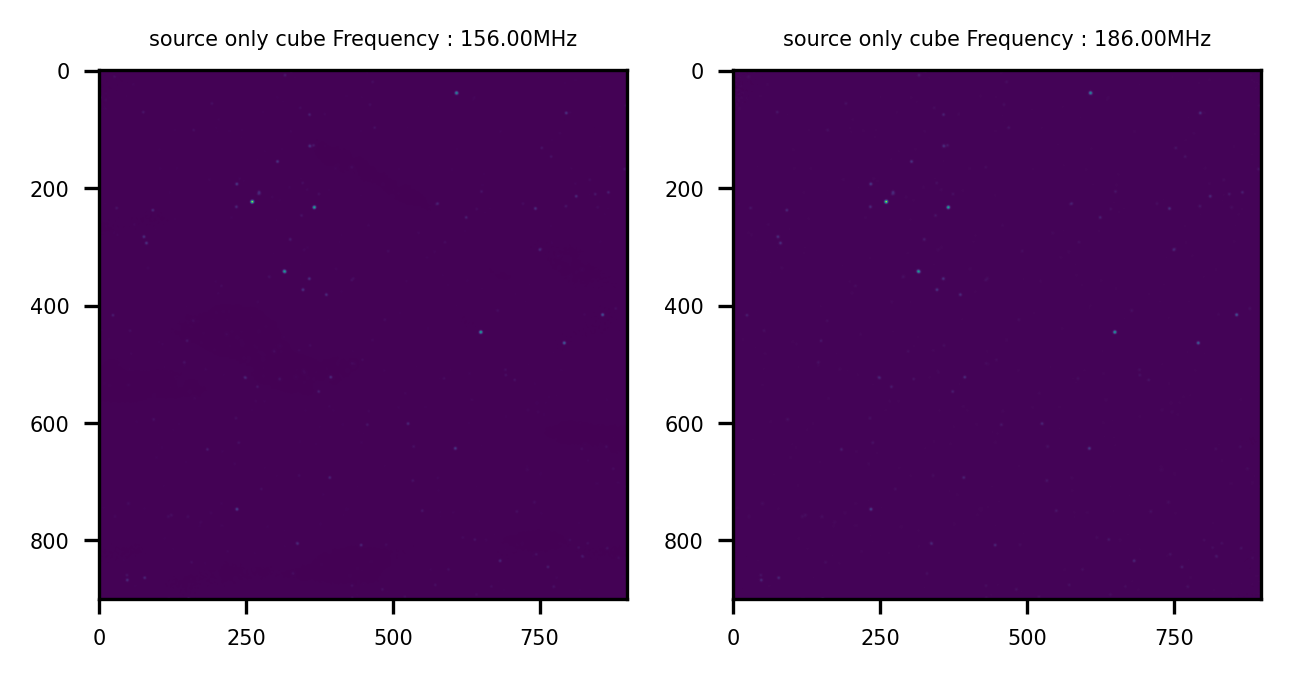

In [68]:
make_obj_cube(crop_cube)
source_cube = fits.open(output_file_path + '/source_only_cube_BS%s_BF%s.fits' %(BACK_SIZE, BACK_FILTERSIZE))[0]

## 6. Subtract the detected source from the original datacube.

Source subtracted cube was created normally.


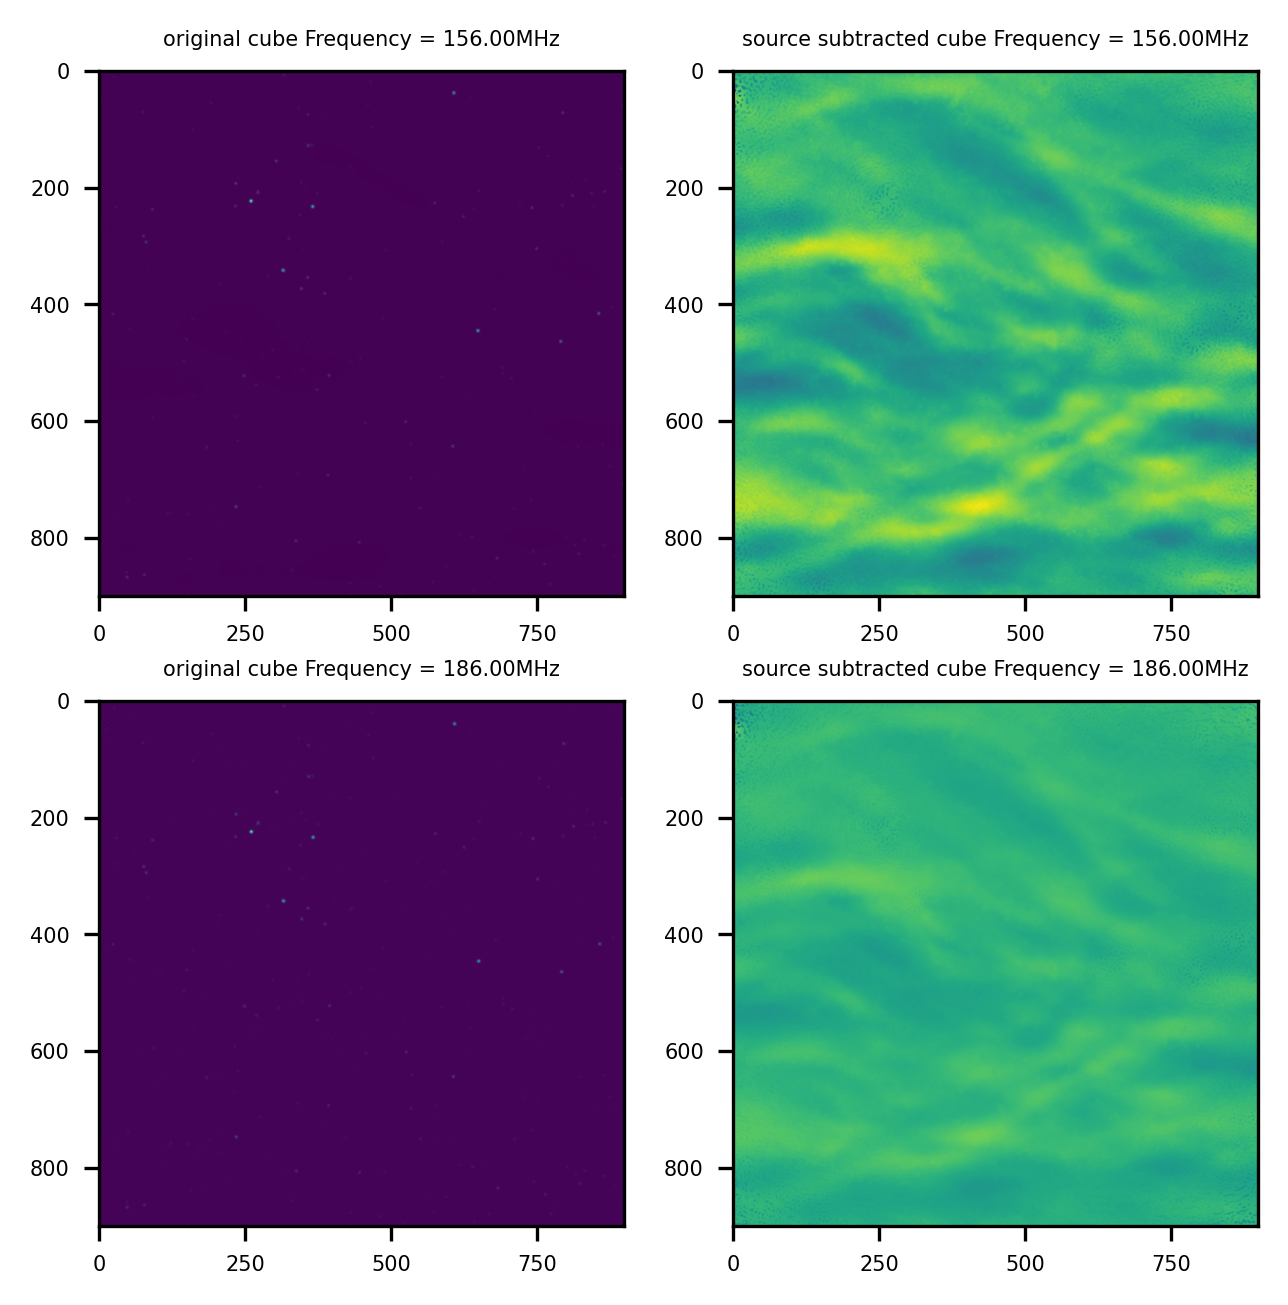

In [69]:
obj_sub_cube(crop_cube, source_cube)

### Now, the beam-corrected & point-source removed Main Dataset is ready for our pipeline! Time to go the the following jupyter notebook:


KORSDC_FGremove/main/Reproducibility_part3_with_beam_corrected_MainDataset.ipynb